## LINE1 energy landscape
* Analysis of LINE1 from previous work: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7449397/
* We extend this analysis with co-evolutionary analysis
    * Calculating ER-defined pairwise coupling and bias (w_ER, b)
    * We use these couplings to characterize the energy landscape

In [1]:
# STEP 1: Import code

import os.path, sys
from pathlib import Path
# Define path to utility code and insert it into jupyter path for import
path_to_utilities = '/data/cresswellclayec/ER_omic/utilities/'
sys.path.insert(0, path_to_utilities)

# Import computational science suite
import numpy as np
np.random.seed(1) # set random seed for numpy for consistency

import pandas as pd
from scipy import linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial import distance_matrix

# Import Bipython
import warnings
import Bio.PDB
from Bio import SeqIO, pairwise2,BiopythonWarning
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
warnings.simplefilter('ignore', BiopythonWarning)

# Import parallel and time-count
from joblib import Parallel, delayed
import timeit
# %matplotlib inline

import matplotlib.pyplot as plt

# # --- Import our Code ---# #
#import emachine as EM
from direct_info import direct_info
# import data processing and general DCA_ER tools
from data_processing import data_processing_msa2pdb
import tools
# # -----------------------# #

In [2]:
# Define data directories
line1_dir = '/data/cresswellclayec/ER_omic/energy_landscape/line1'
data_dir = "%s/line1_data" % line1_dir

In [3]:
# color scheme used in the paper (for plotting)
colors = [(.71,.32,.8),(1.0,.65,0.),(.55,0.,0.),(0,.8,.8),(0.,.55,.55),\
                  (1.0,.1,.58),(0.,0.,.80),(0.4,0.4,0.4)]

### We want to analyse LINE1 protein sequences 
   * We will consider the entire group
   * We can also break up the sequences in chronological families (as done in paper) and treat these families as the different 'sequence backgrounds' from which we will infer pairwise co-evolotionary relations ships (w-coupling) 
   * We will also consider non-evolutionary LINE1 sequences.

In [4]:
# Load all LINE1 sequences
all_seqs = []
with open('%s/all_seqs.fa' % data_dir, 'rU') as f:
    seq_iter = SeqIO.parse(f,'fasta')
    for seq in seq_iter:
        all_seqs.append(seq)

        
# Get the sequence fastA IDs for easch of the families
lp_msas = []
lp_fa_prefix = data_dir
lp_names = ['L1Pa1', 'L1Pa2', 'L1Pa3', 'L1Pa4', 'L1Pa5', 'L1Pa6', 'L1Pa7' ]
total_len = 0
lp_files = ['cls1.1.fasta','cls1.2.fasta','cls123.3.fasta','cls1ab234.4.fasta','cls123.5.fasta','cls1abc234.6.fasta','cls123.7.fasta']
lp_ids = []
for i,filename in enumerate(lp_files):
    lp_msas.append([])
    lp_ids.append([])
    print('Loading MSA for ',lp_names[i])
    with open(lp_fa_prefix+'/'+filename, 'rU') as f:
        seq_iter = SeqIO.parse(f,'fasta')
        for seq in seq_iter:
#             print(seq)
            lp_msas[-1].append(seq.seq) 
            lp_ids[-1].append(seq.id)
    f.close()
#     print(lp_msas[-1][0][:5])
#     print(len(lp_msas[-1]))
    total_len += len(lp_msas[-1])
print('number of all individual LPa MSA sequences: ',total_len)
print('number of all aligned sequences: ',len(all_seqs))


# Load non-stable LINE1 sequences
non_evo_seqs = []
non_evo_ids = []
filename = '%s/151_cc_all_peps_fnl_ed.1.fa' % data_dir
print('Loading MSA for ',filename)
with open(filename, 'rU') as f:
    seq_iter = SeqIO.parse(f,'fasta')
    for seq in seq_iter:
#             print(seq)
        non_evo_seqs.append(seq.seq) 
        non_evo_ids.append(seq.id)
f.close()
non_evo_seqs = np.array([np.array(list(str(record))) for record in non_evo_seqs])


Loading MSA for  L1Pa1
Loading MSA for  L1Pa2
Loading MSA for  L1Pa3
Loading MSA for  L1Pa4
Loading MSA for  L1Pa5
Loading MSA for  L1Pa6
Loading MSA for  L1Pa7
number of all individual LPa MSA sequences:  4341
number of all aligned sequences:  4341
Loading MSA for  /data/cresswellclayec/ER_omic/energy_landscape/line1/line1_data/151_cc_all_peps_fnl_ed.1.fa


In [5]:
# match up sequences between individual family fasta files and full fasta files
# We do this instead of directly loading the familiy fasta files 
# to ensure that the family sequences exist in the full sequence set. (sanity check)
#    - print statements show that the files have all corresponding sequences.
family_ref = []
family_indx = []
for ii,ids in enumerate(lp_names):
    family_indx.append([])
for i,seq in enumerate(all_seqs):
    found = False
    for j,ids in enumerate(lp_ids):
        if seq.id in ids:
            family_ref.append(j)
            family_indx[j].append(i)
            found=True
            break
    if not found:
        print('could not categorize sequence!!')
        
family_ref = np.array(family_ref)
print('all familys contained: ',np.unique(family_ref))
# print('\nnumber of ids attributed to each family:')
for i in range(7):
    family_seqs = family_ref==i
#     print(family_seqs.sum(axis=0))
#     print(len(family_indx[i]))
family_colors = [colors[i] for i in family_ref]

all familys contained:  [0 1 2 3 4 5 6]


### Once we have all our sequences loaded and grouped we will infer coevolutionary coupling (w_ER, b)
* We will get the w_ER matrix for all sequences as well as the sub-group families
* We will also get the PCA embedding for the onehot sequences for visualization

In [6]:
# Get numpy char array of LINE1 sequences
s0 = np.array([seq.seq for seq in all_seqs])
print(s0.shape)

# Get numpy char array of LINE1 sequences and non-evolutionary sequences
full_s0 = np.concatenate((s0,non_evo_seqs), axis=0)

# Get one-hot encoding of all posible sequences (categorical representation for ER-method)
# apply encoding to line1 sequences and non-evolutionary sequences respectively
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
print('s0: ',s0.shape,'\n',s0)
onehot_encoder.fit(full_s0)
s = onehot_encoder.transform(s0)
non_evo_s = onehot_encoder.transform(non_evo_seqs)
print('s: ',s.shape,'\n',s)

(4341, 101)
s0:  (4341, 101) 
 [['Y' 'S' '-' ... 'W' 'D' 'Y']
 ['Y' 'S' '-' ... 'W' 'D' 'Y']
 ['Y' 'S' '-' ... 'W' 'D' 'Y']
 ...
 ['L' 'Y' '-' ... 'W' 'D' 'Y']
 ['Y' 'S' '-' ... 'W' 'D' 'Y']
 ['F' 'C' '-' ... 'W' 'D' 'Y']]
s:  (4341, 1329) 
 [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [7]:
# Get PCA reduction of one-hot data in order to visualize as in the paper
from sklearn.decomposition import PCA
pca_dim=3
pca = PCA(n_components = pca_dim)
s_pca = pca.fit_transform(s)

# Apply pca to difference sets
non_evo_s_pca = pca.transform(non_evo_s)
full_s = np.concatenate((s, non_evo_s))
full_s_pca = pca.transform(full_s)

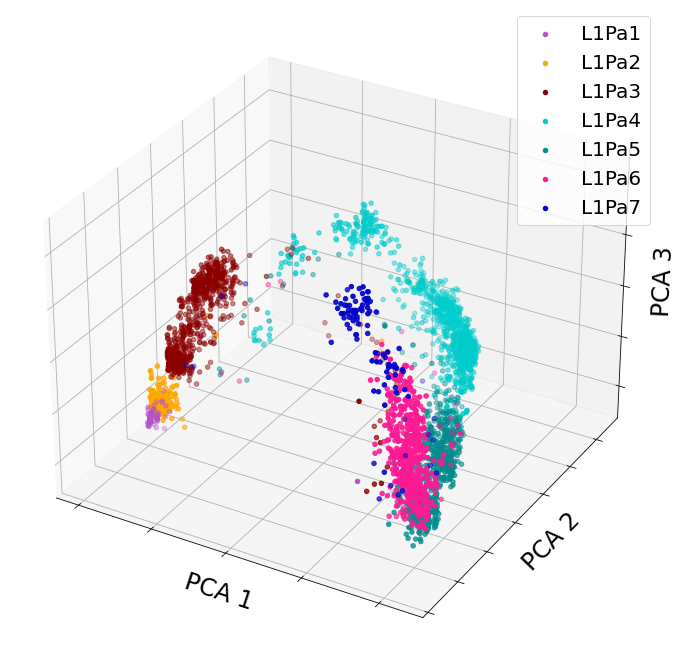

In [8]:
# Plot PCA and visualize evolution/transition of families
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')

ax.set_xlabel('PCA 1', fontsize=24)
ax.set_ylabel('PCA 2', fontsize=24)
ax.set_zlabel('PCA 3', fontsize=24)

ax.get_xaxis().set_ticklabels([])
ax.get_yaxis().set_ticklabels([])
ax.get_zaxis().set_ticklabels([])

for i, fam_indx in enumerate(family_indx):
    ax.scatter(s_pca[fam_indx,0], s_pca[fam_indx,1], s_pca[fam_indx,2], 
               color=colors[i], label=lp_names[i])
plt.legend(fontsize=20)
ax.view_init(30,-60 )
plt.show()


#### Generate w_ER
* Use expectation reflection to infer co-evolutionary relationship between sequence positions

In [9]:
# number of positions
n_var = s0.shape[1]
n_seq = s0.shape[0]

print("Number of residue positions:",n_var)
print("Number of sequences:",n_seq)

# number of aminoacids at each position
mx = np.array([len(np.unique(full_s0[:,i])) for i in range(n_var)])
print("Number of different amino acids at each position",mx)

# total number of onehot variables
mx_cumsum = np.insert(mx.cumsum(),0,0)

# define the START and END OneHot indices of original amino acid positions
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T 
# print(\"(Sanity Check) Column indices of first and (\",i1i2[0],\") and last (\",i1i2[-1],\") positions\")
# print(\"(Sanity Check) Column indices of second and (\",i1i2[1],\") and second to last (\",i1i2[-2],\") positions\")

# number of variables
mx_sum = mx.sum()
print("Total number of variables",mx_sum)

# number of bias term
n_linear = mx_sum - n_var

Number of residue positions: 101
Number of sequences: 4341
Number of different amino acids at each position [16 11  7 11 16 14 18 15 12 13 17 15 12 14 15 13 13 17 16 11 18 16 15 11
 17 12 12 11 12 14 16 16 12 13 22 13 16 18 13  9 13 12 10 15 13 15  2 13
 15  3 15 13 17 16 13 15 16 13  2 16 18 12 18 13 12 16 16 11 13 12 13 12
 13 14 12 12  9 14  2 12 16 13 14 11 12 12 14 13 12 14 14  7 14 13 13 10
 13 10 14 14 13]
Total number of variables 1329


##### w_ER and b for all sequences
* This code will be the same between all sequences and the familiy sequence background, we simply change the `s_train` definition to be all sequences and family sequences

In [10]:
from joblib import Parallel, delayed                                                                     
import expectation_reflection as ER    

# useful calculation to have mean-adjusted sequences
s_centered = s - s.mean(axis=0)      

# we want to use all sequences
s_train = s 

# Define w matrix with variable for each possible amino acid at each sequence position               
w_ER = np.zeros((mx.sum(),mx.sum()))                                                                     
h0 = np.zeros(mx.sum())             

# Expectation Reflection                                                                                 
#=========================================================================================#
# Define parallel run for ER-fit method
def predict_w(s,i0,i1i2,niter_max,l2):                                                                   
    #print('i0:',i0)                                                                                     
    i1,i2 = i1i2[i0,0],i1i2[i0,1]                                                                        
    x = np.hstack([s[:,:i1],s[:,i2:]])                                                                   
    y = s[:,i1:i2]                                                                                       
    h01,w1 = ER.fit(x,y,niter_max,l2)                                                                    
    return h01,w1                                                                                        

# define files to save results to
w_file = "%s/w.npy" % (data_dir)   
wsym_file = "%s/w_sym.npy" % (data_dir)   
b_file = "%s/b.npy" % (data_dir)        


# w_ER calculation can be time consuming so it may be better to load it
create_new = False # set True if you want to compute a new w_ER regardless
if os.path.exists(w_file) and not create_new:                                                          
    w_ER = np.load(w_file)      
    w_ER_sym = np.load(w_file)                                                                               
    b = np.load(b_file)                                                                                                               
else:                                                                                                    
    #-------------------------------                                                                     
    # parallel                                                                                           
    start_time = timeit.default_timer()                                                                  
    res = Parallel(n_jobs = 20-2)(delayed(predict_w)                                                   
            (s_train,i0,i1i2,niter_max=10,l2=100.0)                                                          
            for i0 in range(n_var))                                                                      
                                                                                                         
    run_time = timeit.default_timer() - start_time                                                       
    print('run time:',run_time)                                                                          
    #------------------------------- 
    for i0 in range(n_var):
        i1,i2 = i1i2[i0,0],i1i2[i0,1]                                                                    
        
        h01 = res[i0][0]                                                                                 
        w1 = res[i0][1]
        
        h0[i1:i2] = h01                                                                                  
        w_ER[:i1,i1:i2] = w1[:i1,:]                                                                      
        w_ER[i2:,i1:i2] = w1[i1:,:]                                                                      
        
    # make w symmetric                                                                                   
    w_ER_sym = (w_ER + w_ER.T)/2.            
    b = h0
    
    np.save(w_file, w_ER)
    np.save(wsym_file, w_ER_sym)
    np.save(b_file, b)


#### We can now calculate the energy-difference between sequences.
* This is essentially calculating the expectation of seeing a sequence given another sequence


In [11]:
from er_energy import energy_diff
from scipy.spatial import distance

print('identity energy difference: ', energy_diff(i1i2,s_train[1,:], s_train[1,:], w_ER, b, return_pos_array=True))
print('seq 1 vs 2 energy difference: ', energy_diff(i1i2,s_train[1,:],s_train[2,:],w_ER, b))
# can also use the hamming distance as a analgous difference measurment.
# In this case the small hamming distance of .01 explains a relatively small difference
# between the identity difference of 5181 and the 1vs2 sequence difference of 5192
print('seq 1 vs seq2 hamming distance: ', distance.squareform(distance.pdist(s_train[1:3,:], 'hamming')))
print(distance.squareform(distance.pdist([s_train[1,:],s_train[2,:]], 'hamming'))[0][1])

identity energy difference:  (5181.416494522975, array([3.5912731 , 4.71408731, 4.30317998, ..., 4.09549283, 4.45043576,
       4.53264597]))
seq 1 vs 2 energy difference:  5192.892811521908
seq 1 vs seq2 hamming distance:  [[0.         0.01053424]
 [0.01053424 0.        ]]
0.010534236267870579


#### Compute Sequence energy difference by family
* We can use this notion to look at the expectation of seeing a given sequence in the context of a LINE1 family
    * We do this by calculating w_ER per family (using the family sequences as sequence background to infer the couplings)
    * With the family specific w_ER we look at the 'expectation' of a sequence given the mean sequence in the family.
    * Note: calculating the sequence energy can be done differently by simple calcluating the sequence energy directly instead of comparing it to the family-mean sequence
                   

In [12]:
# Get W-er for all families
#    -- Allows us to calculate the sequence energy using different "sequence backgrounds"
w_families = []
w_sym_families = []
b_families = []
for msa_id in range(7):
    w_file = "%s/w_%s.npy" % (data_dir,lp_names[msa_id]) 
    w_sym_file = "%s/w_sym_%s.npy" % (data_dir,lp_names[msa_id]) 
    b_file = "%s/b_%s.npy" % (data_dir,lp_names[msa_id])        

    if os.path.exists(w_file):
#     if 0:
        w_fam = np.load(w_file)
        w_sym_fam = np.load(w_sym_file)
        b_fam = np.load(b_file)
    else:
        w_fam = np.zeros((mx.sum(),mx.sum()))                                                                     
        h0 = np.zeros(mx.sum()) 
            #-------------------------------                                                                     
        # parallel  
        s_msa = s_train[family_indx[msa_id]]
        start_time = timeit.default_timer()                                                                  
        res = Parallel(n_jobs = 20-2)(delayed(predict_w)                                                   
                (s_msa,i0,i1i2,niter_max=10,l2=100.0)                                                          
                for i0 in range(n_var))                                                                      

        run_time = timeit.default_timer() - start_time                                                       
        print('family %d run time:' %msa_id ,run_time)                                                                          
        #------------------------------- 
        for i0 in range(n_var):
            i1,i2 = i1i2[i0,0],i1i2[i0,1]                                                                    

            h01 = res[i0][0]                                                                                 
            w1 = res[i0][1]

            h0[i1:i2] = h01                                                                                  
            w_fam[:i1,i1:i2] = w1[:i1,:]                                                                      
            w_fam[i2:,i1:i2] = w1[i1:,:]                                                                      

        # make w symmetric     
        b_fam = h01
        w_sym_fam = (w_fam + w_fam.T)/2.   
        np.save(b_file, b_fam)
        np.save(w_sym_file, w_sym_fam)
        np.save(w_file, w_fam)

    b_families.append(h0)
    w_families.append(w_fam)
    w_sym_families.append(w_sym_fam)

In [13]:
# Get sequences in w_ER-eigenspace of different families
s_families_ER = [] # list of full msa embeded in all family sequences spaces
for i,w_fam in enumerate(w_families):
    # get sequences space for family
#     print(len(family_indx[i]))
    w_f, v_f  = np.linalg.eigh(w_fam)
    fam_mean = np.mean(s[family_indx[i]],axis=0)
    s_families_ER.append(tools.ER_transform(s,v_f, mean = fam_mean))
gps_ER = []
for ii, msa in enumerate(s_families_ER):
    gps_ER.append([])
    for i in range(len(s_families_ER)):
        gps_ER[-1].append(np.array(list(zip(msa[family_indx[i],0], msa[family_indx[i],1],msa[family_indx[i],2]))))


#### Calculate Energy of all sequences in different Contexts
* using the sequence background (ie from the perspective of) the different families

In [14]:

# Calulate sequence energy of all sequences from the perspective of different 
# "sequence backgrounds"
if not os.path.exists('%s/gp0_SvsAVG_energy.npy'%data_dir):
    s_E_rows = []
    for msa_indx, w_fam in enumerate(w_sym_families):
        b_fam = b_families[msa_indx]
        gp_mean = np.mean(s[family_indx[msa_indx]], axis=0)
        s_E_row = np.zeros(len(full_s))
        print(energy_diff(i1i2,gp_mean,full_s[0,:],w_sym_fam,b_fam))
        # serial energy computation
#         s_E_row = []
#         for seq in full_s:
#             s_E_row.append(np.array(energy_diff(i1i2,gp_mean,seq,w_fam,b_fam)))
#         s_E_row = np.array(s_E_row)
#         s_E_rows.append(s_E_row)
        # parallel energy computation
        res = Parallel(n_jobs = 20-2)(delayed(energy_diff)
                (i1i2,gp_mean,full_s[i0,:],w_sym_fam,b_fam)
                for i0 in range(len(full_s)))
        s_E_row = np.array(res)
        print(s_E_row.shape)
        s_E_rows.append(s_E_row)
        np.save('%s/gp%d_SvsAVG_energy.npy' % (data_dir,msa_indx), s_E_row)
else:
    s_E_rows = []
    for i in range(len(gps_ER)):
        s_E_rows.append(np.load('%s/gp%d_SvsAVG_energy.npy' % (data_dir, i)))


In [15]:
# PCA space contours.
from sklearn.decomposition import PCA


# Choose which LP family you want as default focus for sequence background
msa_1 = 2
msa_2 = msa_1+1
indx_12 = np.concatenate((family_indx[msa_1],family_indx[msa_2]))

pca = PCA(n_components=2).fit(s[indx_12])                                                                         
pca_s = pca.transform(s)
print('original sequences shape: ', s_train.shape)                                                   
print('pca-embed: ', pca.components_.shape)                                                          


original sequences shape:  (4341, 1329)
pca-embed:  (2, 1329)


#### Plot the Sequence energy landscape!
* this landscape is analgous to the fitness landscape in the evolutionary context of each of the sequence families
* This is plotted in PCA1 and PCA2
* We plot LINE1 families 3 and 4 (L1Pa3 and L1Pa4) in the evolutionary context of L1Pa3 
    * using L1Pa3 family sequences as the sequence background to calculate w_ER, b

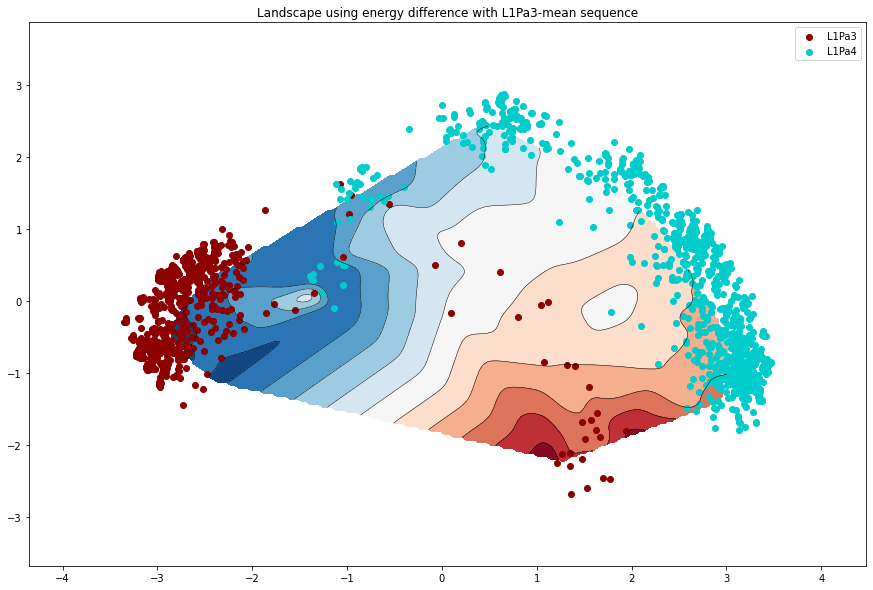

In [16]:
from scipy.ndimage.filters import gaussian_filter
import matplotlib.tri as tri                                                                                                     
from matplotlib.lines import Line2D

# Get clear plotting components for legend
legend_elements = [Line2D([0], [0], color=colors[i], marker='o', label=lp_names[i]) for i in range(7)]


x = pca_s[indx_12,0]
y = pca_s[indx_12,1]
z = s_E_rows[msa_1][indx_12]

fig = plt.figure(figsize=(15,10))
ax  = fig.add_subplot(111)

gp1_mean = np.mean(pca_s[family_indx[msa_1]], axis=0)

# Create grid values first.
ngridx = 200
ngridy = 200
xi = np.linspace(min(x)-1, max(x)+1, ngridx)
yi = np.linspace(min(y)-1, max(y)+1, ngridy)

# Perform linear interpolation of the data (x,y)
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)

Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)
Zi = gaussian_filter(zi, sigma=2.)

ax.contour(Xi, Yi, Zi, levels=10, linewidths=0.5, colors='k')
cntr1 = ax.contourf(Xi, Yi, Zi, levels=10, cmap="RdBu_r")
                                                                              

ax.scatter(pca_s[family_indx[msa_1],0], pca_s[family_indx[msa_1],1], color=colors[msa_1], label=lp_names[msa_1])  
ax.scatter(pca_s[family_indx[msa_2],0], pca_s[family_indx[msa_2],1], color=colors[msa_2], label=lp_names[msa_2])                                                                               

ax.scatter(gp1_mean[0], gp1_mean[1], marker='*',color=colors[msa_1],s=100)
plt.legend()
plt.title('Landscape using energy difference with %s-mean sequence'%lp_names[msa_1])
plt.show()

### Calculate the Energy/Fitness Landscape for all families
* Iterating through consecutive paiurs of families calculate the sequence energy landscape 
* These plots are grouped by rows of 2 --> from the pre- and post- family perspective 
* The energy landscape is calculated using ALL the sequences
* Only the sequences from the pair families are plotted.
* The dimensions are all combinations of PCA 1, 2, and 3

Plotting L1Pa1 and L1Pa2
Plotting L1Pa2 and L1Pa3
Plotting L1Pa3 and L1Pa4
Plotting L1Pa4 and L1Pa5
Plotting L1Pa5 and L1Pa6
Plotting L1Pa6 and L1Pa7


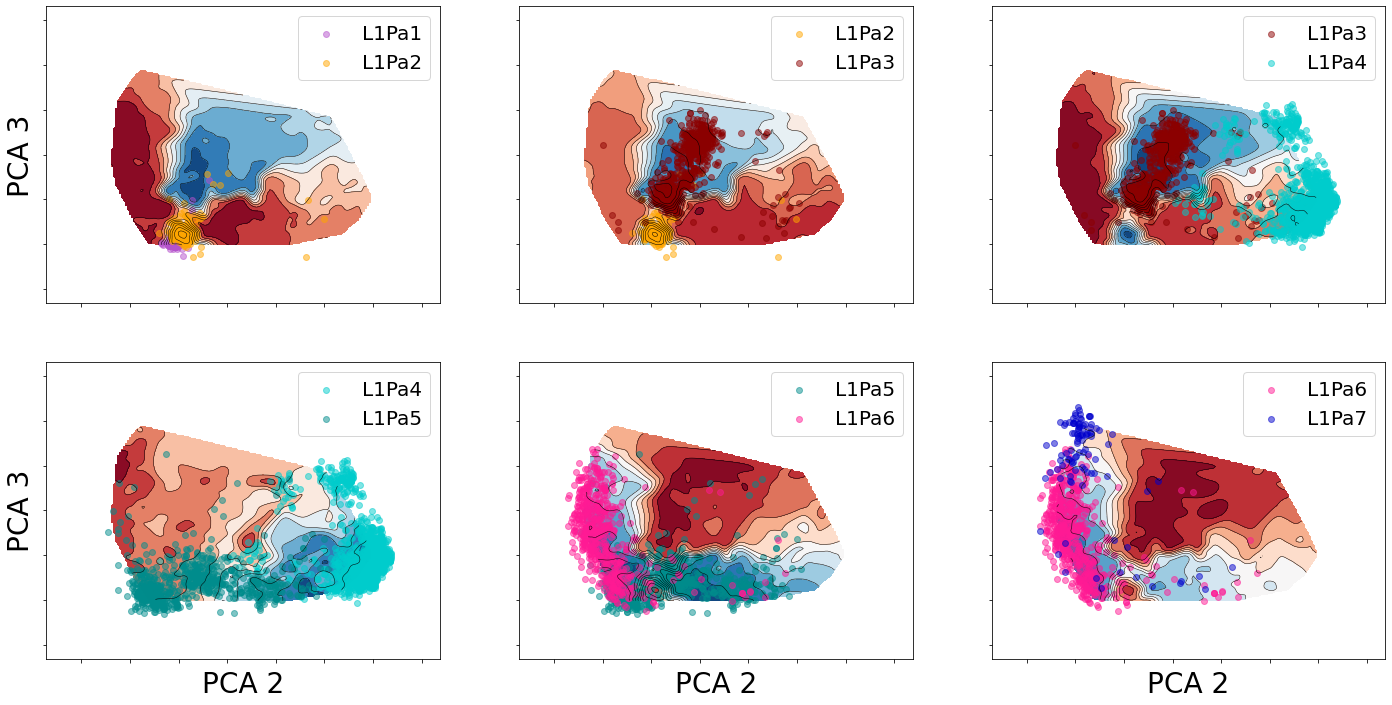

In [66]:
pca = PCA(n_components=3).fit(s)                                                                   
full_pca_s = pca.transform(full_s)
pca_s = pca.transform(s)

fig1 = plt.figure(figsize=(24,12))

ax1  = fig1.add_subplot(231)    
ax2  = fig1.add_subplot(232)    
ax3  = fig1.add_subplot(233)    
ax4  = fig1.add_subplot(234)    
ax5  = fig1.add_subplot(235)    
ax6  = fig1.add_subplot(236)  
ax1.get_shared_x_axes().join(ax4)
ax2.get_shared_x_axes().join(ax5)
ax3.get_shared_x_axes().join(ax6)
ax1.get_shared_y_axes().join(ax2, ax3)
ax4.get_shared_y_axes().join(ax5, ax6)

axes = [ax1, ax2, ax3, ax4, ax5, ax6]

dim_1 = 1
dim_2 = 2
for i in range(len(w_families)-1):
    msa_1 = i
    msa_2 =msa_1+1
    print('Plotting %s and %s' % (lp_names[msa_1], lp_names[msa_2]))

        # get sequence count to sample
    # the number of sequences per family may introduce bias
    gp1_indx = family_indx[msa_1] 
    gp2_indx = family_indx[msa_2]
    

    x = pca_s[:,dim_1]
    y = pca_s[:,dim_2]
    z = s_E_rows[msa_1][:-len(non_evo_seqs)]

    gp1_mean = np.mean(pca_s[family_indx[msa_1]], axis=0)

    # Create grid values first.
    ngridx = 200
    ngridy = 200
    xi = np.linspace(min(x)-1, max(x)+1, ngridx)
    yi = np.linspace(min(y)-1, max(y)+1, ngridy)

    # Perform linear interpolation of the data (x,y)
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z)

    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    Zi = gaussian_filter(zi, sigma=2.)

    axes[i].contour(Xi, Yi, Zi, levels=10, linewidths=0.5, colors='k')
    cntr1 = axes[i].contourf(Xi, Yi, Zi, levels=10, cmap="RdBu_r")
    
    # plot the sequence points for both families
    axes[i].scatter(pca_s[gp1_indx,dim_1], pca_s[gp1_indx,dim_2], color=colors[msa_1],
                    alpha=.5, label=lp_names[msa_1])
    axes[i].scatter(pca_s[gp2_indx,dim_1], pca_s[gp2_indx,dim_2], color=colors[msa_2],
                    alpha=.5, label=lp_names[msa_2])

    axes[i].get_xaxis().set_ticklabels([])
    axes[i].get_yaxis().set_ticklabels([])

    axes[i].legend(fontsize=20)
ax1.set_ylabel('PCA %d' % (dim_2+1), fontsize=28)
ax4.set_ylabel('PCA %d' % (dim_2+1), fontsize=28)

ax4.set_xlabel('PCA %d' % (dim_1+1), fontsize=28)
ax5.set_xlabel('PCA %d' % (dim_1+1), fontsize=28)
ax6.set_xlabel('PCA %d' % (dim_1+1), fontsize=28)
plt.savefig('Line1_family_energy.png',
            transparent=True, dpi=500,bbox_inches='tight')
plt.show()

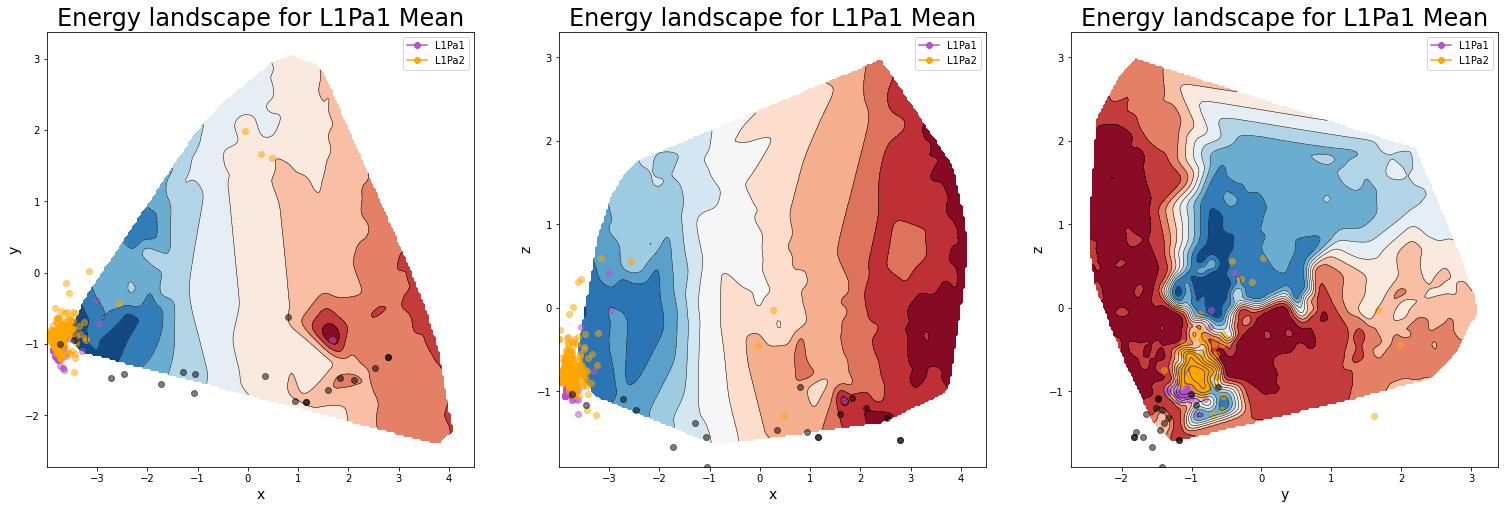

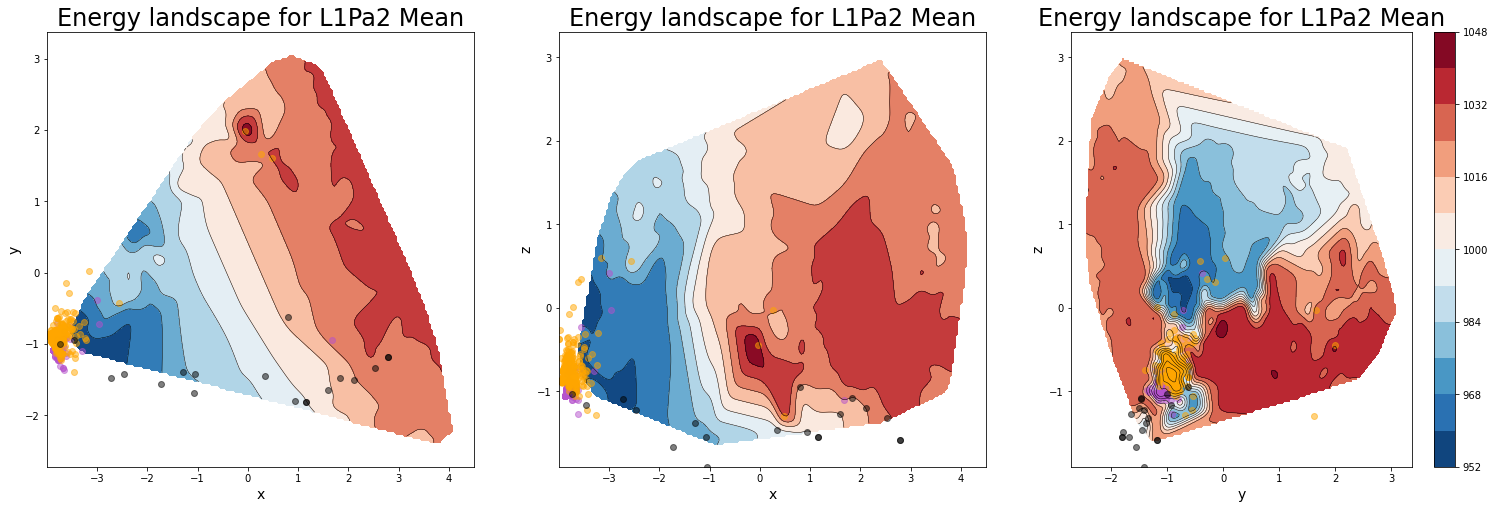

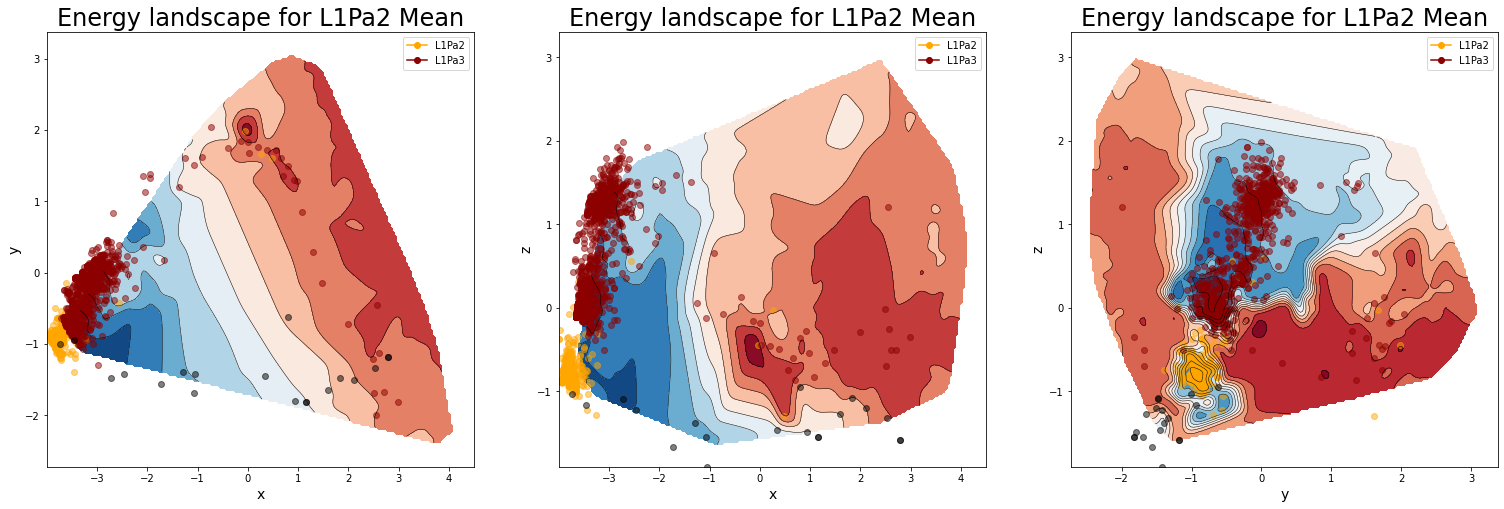

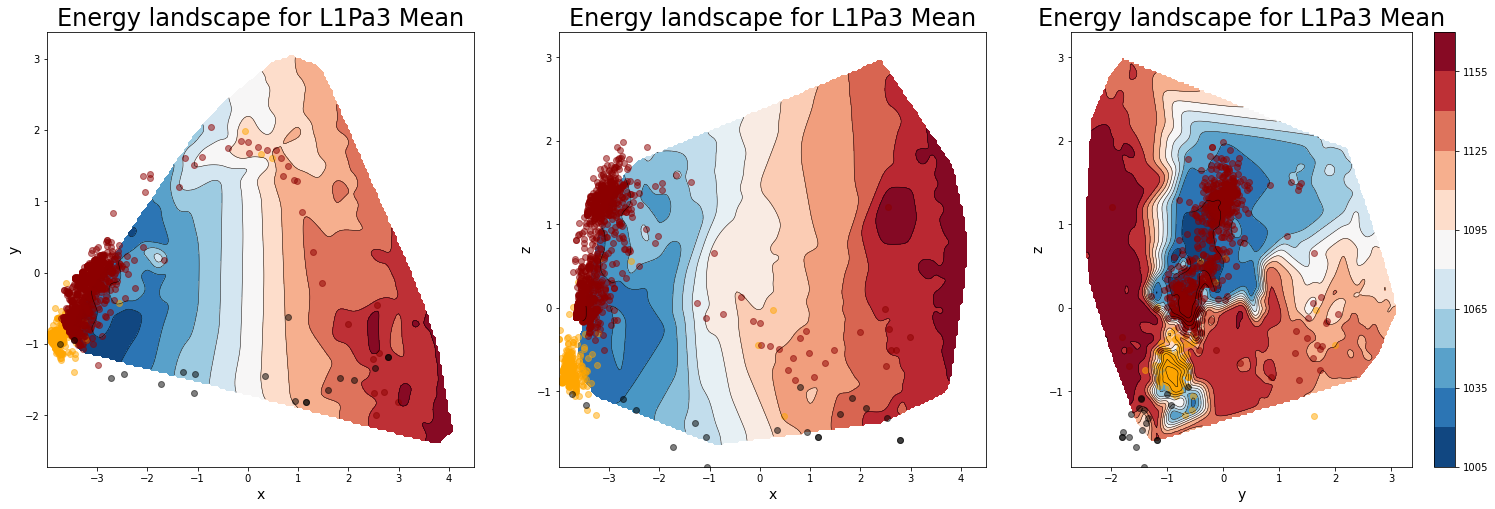

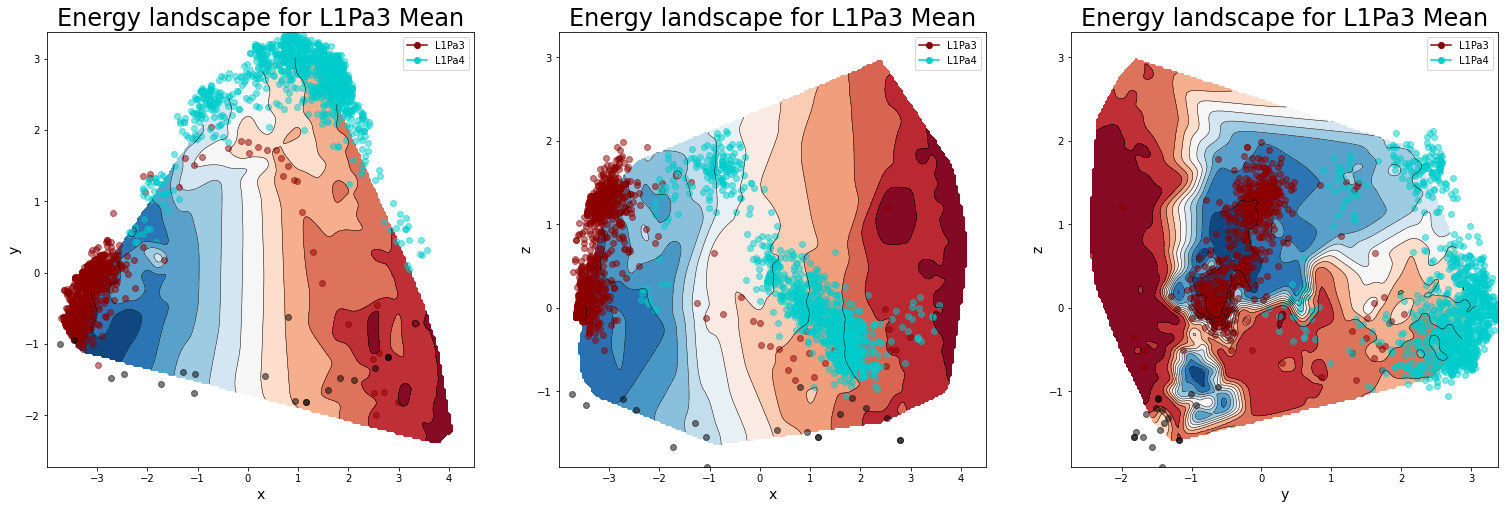

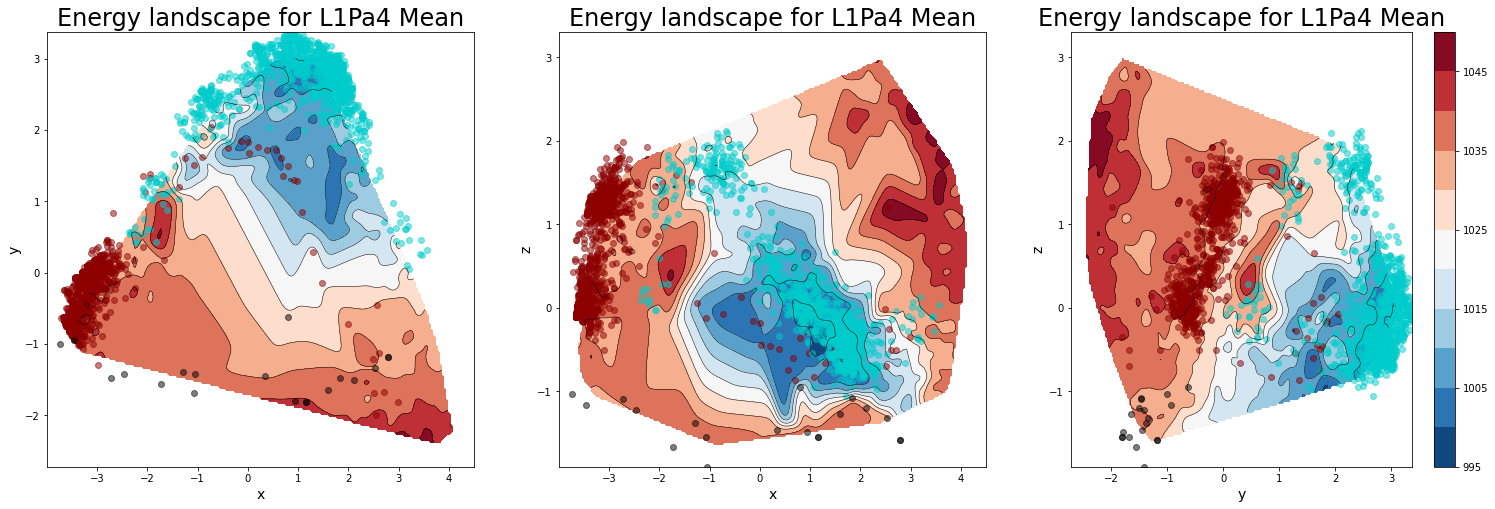

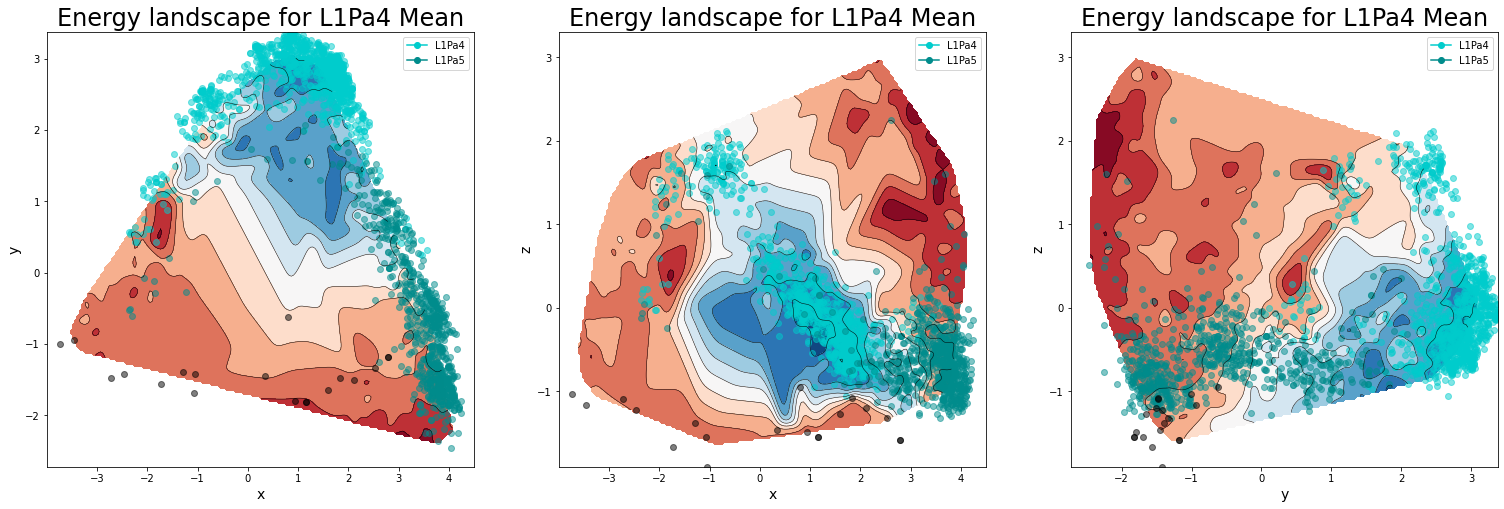

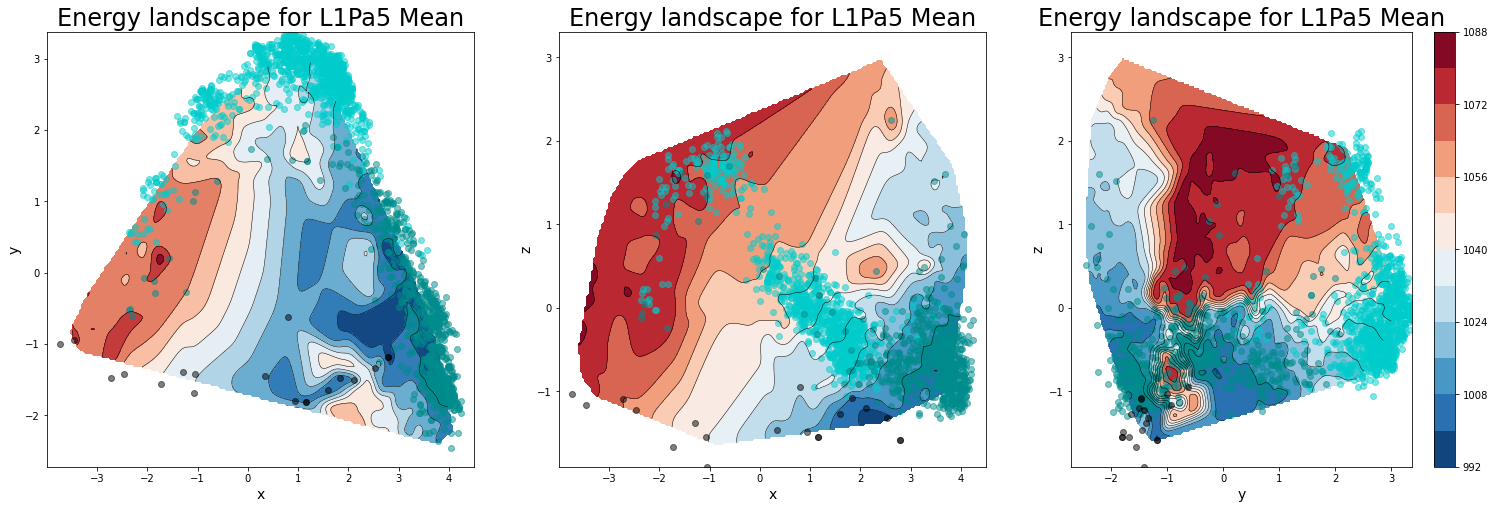

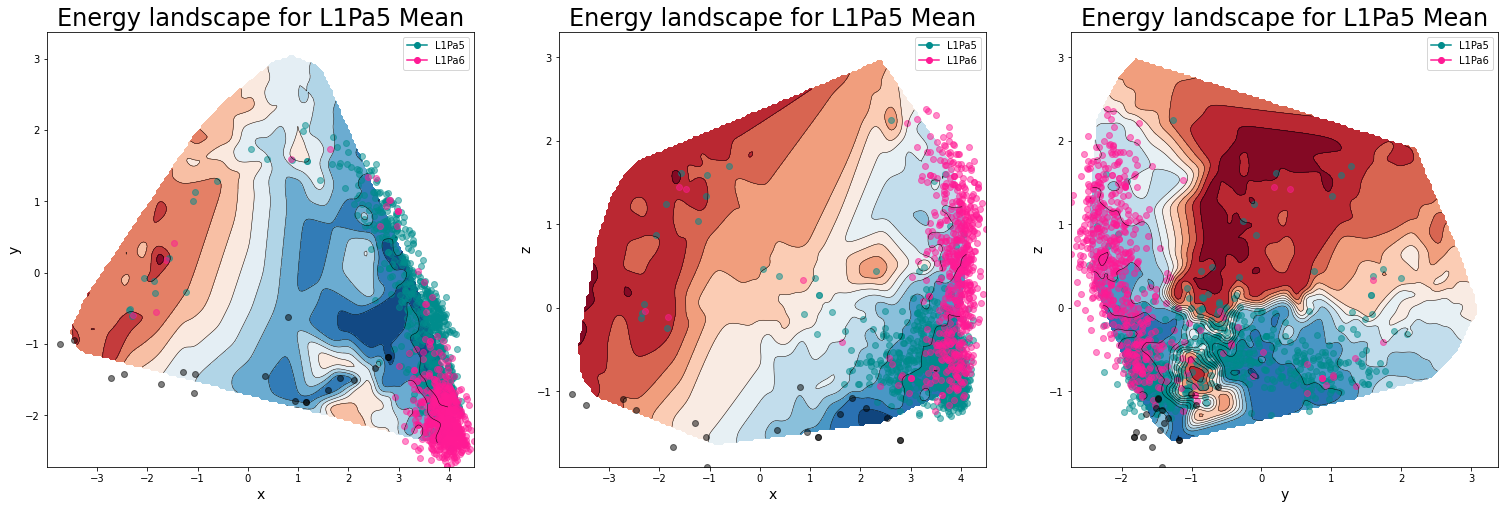

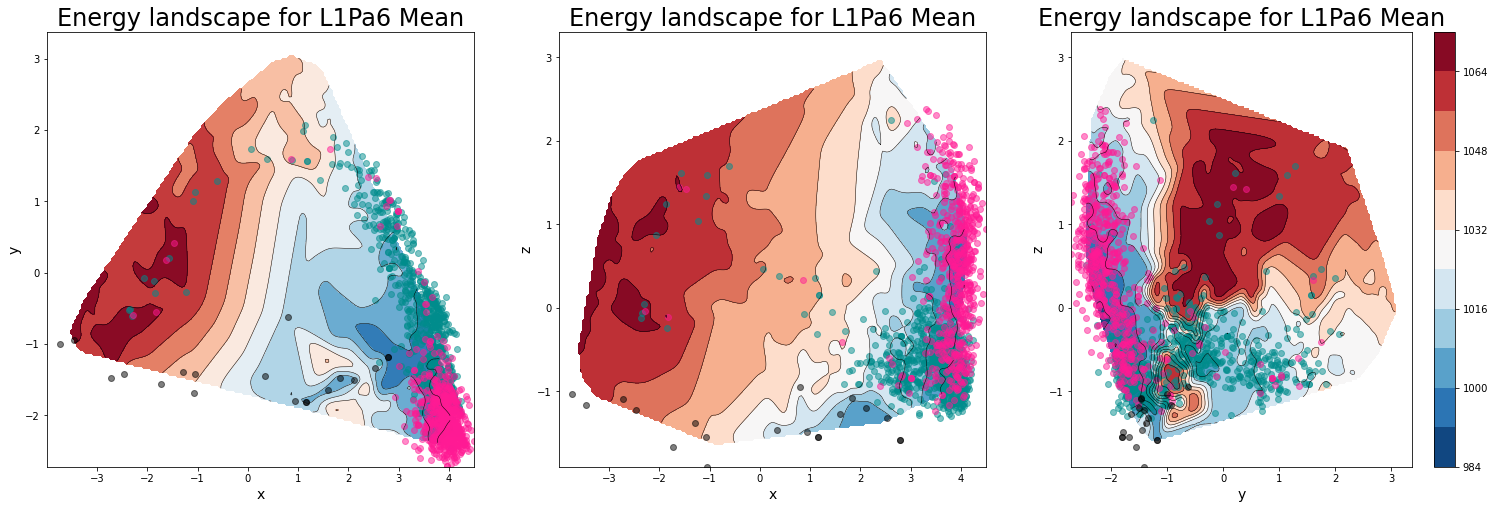

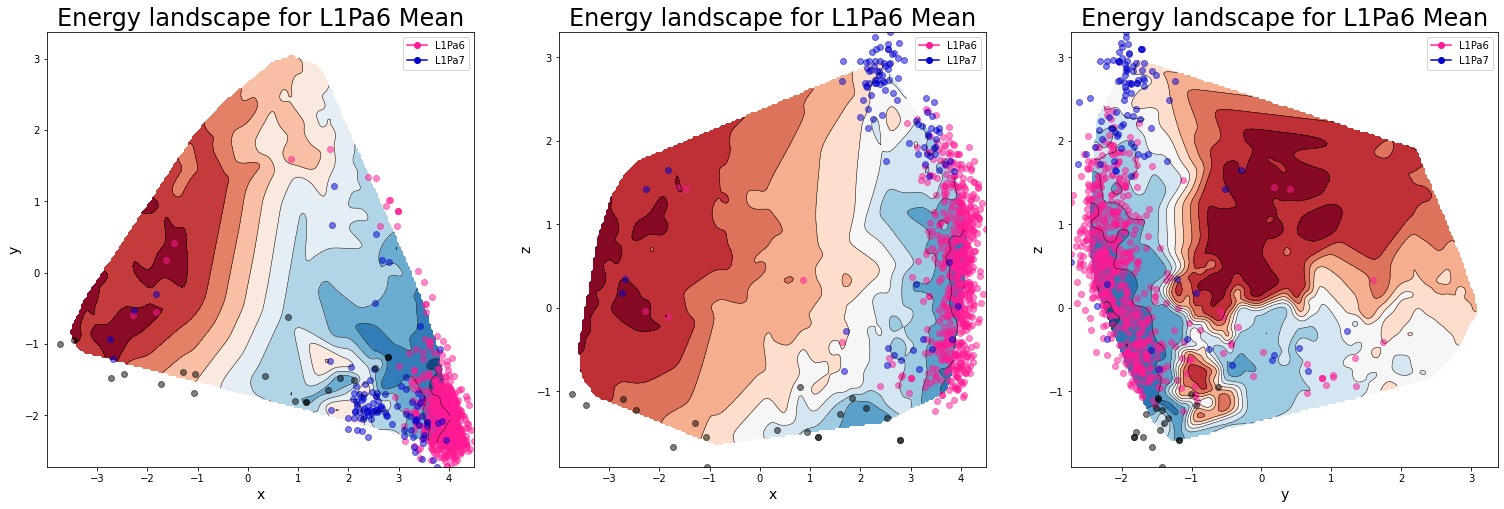

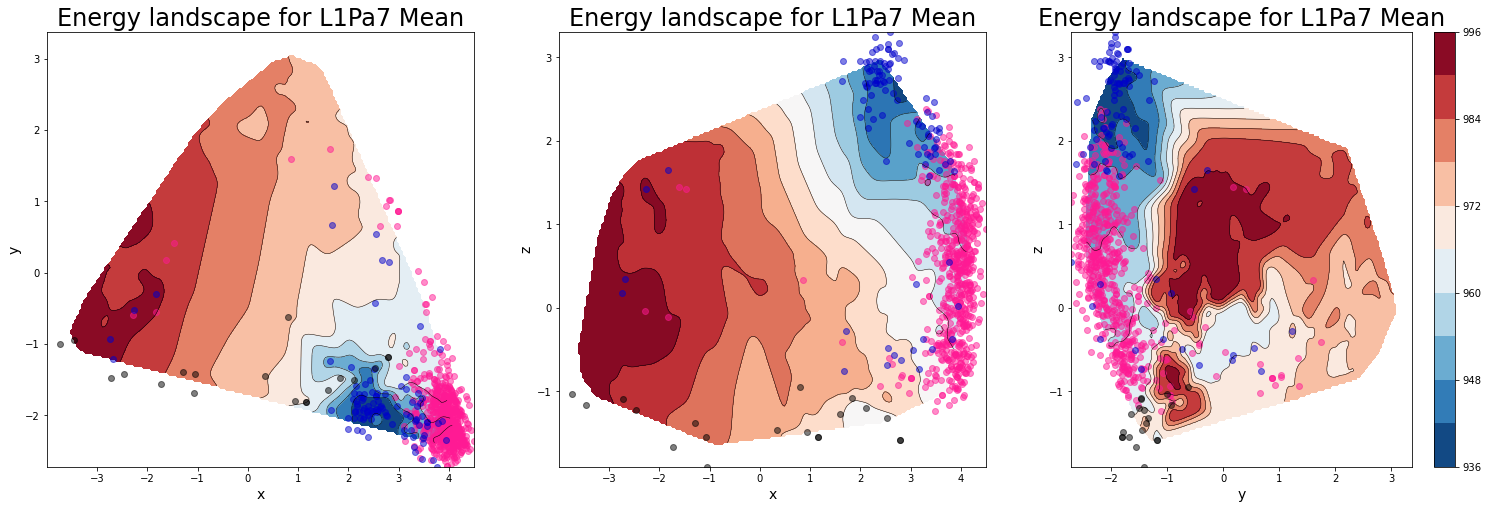

In [45]:
from scipy.spatial import distance
s0_len = len(s0)

# for i in range(len(w_families)):
#     print(s_E_rows[i][:5])

for i in range(len(w_families)-1):
    fig1 = plt.figure(figsize=(26,8))
    fig2 = plt.figure(figsize=(26,8))

    ax1  = fig1.add_subplot(131)    
    ax2  = fig1.add_subplot(132)    
    ax3  = fig1.add_subplot(133)    
    ax4  = fig2.add_subplot(131)    
    ax5  = fig2.add_subplot(132)    
    ax6  = fig2.add_subplot(133)    

    msa_1 = i
    msa_2 =msa_1+1

    # get sequence count to sample
    # the number of sequences per family may introduce bias
    gp1_indx = family_indx[msa_1] 
    gp2_indx = family_indx[msa_2]

    gp1_mean = np.mean(s[gp1_indx],axis=0)
    gp2_mean = np.mean(s[gp2_indx],axis=0)
    w_gp1 = w_families[msa_1]
    w_gp2 = w_families[msa_2]
    
    indx_12 = np.concatenate((gp1_indx,gp2_indx))
    s_12 = s[indx_12]

    gp1_mean_pca = pca.transform([gp1_mean])[0]


    z1 = s_E_rows[msa_1]
    z2 = s_E_rows[msa_2]

#     print('%d energy: ' % msa_1, z1)
#     print('%d energy: ' % msa_2, z2)

    planes = [(0,1),(0,2),(1,2)] # indices to plot x/y, x/z, and y/z planes
    ax_labels = ['x', 'y' , 'z']
    axes1 = [ax1, ax2, ax3]  # panel 1 to plot the different planes for msa 1
    axes2 = [ax4, ax5, ax6]  # panel 2 to plot the different planes for msa 2

    for dim in range(3):
        try:
            x = full_pca_s[:,planes[dim][0]]
            y = full_pca_s[:,planes[dim][1]]
    #         print('x', x.shape)
    #         print('y', y.shape)

            n_levels=10
            sigma = .001
            # Create grid values first.
            ngridx = 200
            ngridy = 200
            xi = np.linspace(min(x), max(x), ngridx)
            yi = np.linspace(min(y), max(y), ngridy)


            # Perform linear interpolation of the data (x,y)
            # on a grid defined by (xi,yi)
            triang = tri.Triangulation(x, y)


            interpolator1 = tri.LinearTriInterpolator(triang, z1)
            interpolator2 = tri.LinearTriInterpolator(triang, z2)
        except(ValueError): # do not have scores for non-evo x,y longer because we have pca for non-evo
            x = pca_s[:,planes[dim][0]]
            y = pca_s[:,planes[dim][1]]
#             print('x', x.shape)
#             print('y', y.shape)

            n_levels=10
            sigma = .001
            # Create grid values first.
            ngridx = 200
            ngridy = 200
            xi = np.linspace(min(x), max(x), ngridx)
            yi = np.linspace(min(y), max(y), ngridy)

            # Perform linear interpolation of the data (x,y)
            # on a grid defined by (xi,yi)
            triang = tri.Triangulation(x, y)

            interpolator1 = tri.LinearTriInterpolator(triang, z1)
            interpolator2 = tri.LinearTriInterpolator(triang, z2)        # interpolator = tri.CubicTriInterpolator(triang, z)

        # interpolator = tri.CubicTriInterpolator(triang, z)

        Xi, Yi = np.meshgrid(xi, yi)

        zi1 = interpolator1(Xi, Yi)
        Zi1 = gaussian_filter(zi1, sigma=2.)

        zi2 = interpolator2(Xi, Yi)
        Zi2 = gaussian_filter(zi2, sigma=2.)    

        # ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
        # cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
        axes1[dim].contour(Xi, Yi, Zi1, levels=10, linewidths=0.5, colors='k')
        cntr11 = axes1[dim].contourf(Xi, Yi, Zi1, levels=10, cmap="RdBu_r")

        axes2[dim].contour(Xi, Yi, Zi2, levels=10, linewidths=0.5, colors='k')
        cntr12 = axes2[dim].contourf(Xi, Yi, Zi2, levels=10, cmap="RdBu_r")   
        if dim==2:
            cbar = plt.colorbar(cntr12)
        # plot the sequence points for both families
        axes1[dim].scatter(pca_s[gp1_indx,planes[dim][0]], pca_s[gp1_indx,planes[dim][1]], color=colors[msa_1],alpha=.5)  
        axes1[dim].scatter(pca_s[gp2_indx,planes[dim][0]], pca_s[gp2_indx,planes[dim][1]], color=colors[msa_2],alpha=.5)                                                                               
        axes1[dim].scatter(full_pca_s[s0_len:,planes[dim][0]], full_pca_s[s0_len:,planes[dim][1]], label='Outliers',color='k',alpha=.5,marker='o')

        
        axes2[dim].scatter(pca_s[gp1_indx,planes[dim][0]], pca_s[gp1_indx,planes[dim][1]], color=colors[msa_1],alpha=.5)  
        axes2[dim].scatter(pca_s[gp2_indx,planes[dim][0]], pca_s[gp2_indx,planes[dim][1]], color=colors[msa_2],alpha=.5)                                                                               
        axes2[dim].scatter(full_pca_s[s0_len:,planes[dim][0]], full_pca_s[s0_len:,planes[dim][1]], label='Outliers',c='k',alpha=.5,marker='o')                                                                               


        # plot the mean value perturbed and the boundary sequence of the descendant
        # fin closest descendant
        min_dist = 100000.
        for ii, msa2_seq in enumerate(s[family_indx[msa_2]]):
            pt_dist = distance.pdist((gp1_mean,msa2_seq))
            if pt_dist < min_dist:
                min_dist = pt_dist
                min_id = ii
        boundary_seq = s[family_indx[msa_2]][min_id]
        boundary_seq_pca = pca_s[family_indx[msa_2]][min_id]

        axes1[dim].legend(handles=legend_elements[i:i+2])
        axes1[dim].set_title('Energy landscape for %s Mean'% lp_names[msa_1],fontsize=24)
        axes2[dim].set_title('Energy landscape for %s Mean'% lp_names[msa_2],fontsize=24)
        axes1[dim].set_xlabel(ax_labels[planes[dim][0]],fontsize=14)
        axes1[dim].set_ylabel(ax_labels[planes[dim][1]],fontsize=14)
        axes2[dim].set_xlabel(ax_labels[planes[dim][0]],fontsize=14)
        axes2[dim].set_ylabel(ax_labels[planes[dim][1]],fontsize=14)


### Lets consider a specifc family case
* L1Pa2 and L1Pa3
* Try to predict the mutation path throught the 'energy canyon'

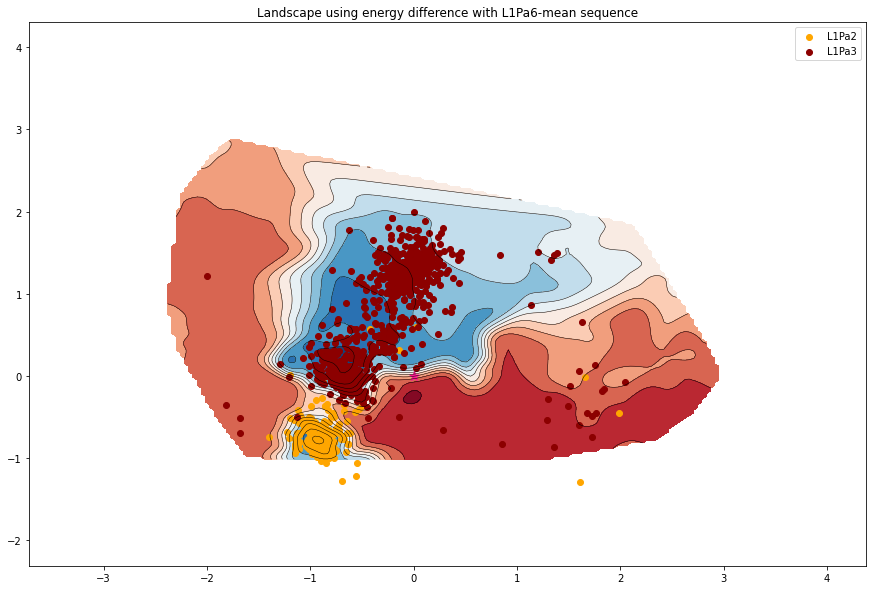

In [46]:
# Get clear plotting components for legend
legend_elements = [Line2D([0], [0], color=colors[i], marker='o', label=lp_names[i]) for i in range(7)]

msa_2 = 1
msa_3 =msa_2+1

# get sequence count to sample
# the number of sequences per family may introduce bias
gp2_indx = family_indx[msa_2] 
gp3_indx = family_indx[msa_3]

gp2_mean = np.mean(s[gp2_indx],axis=0)
gp3_mean = np.mean(s[gp3_indx],axis=0)


indx_23 = np.concatenate((gp2_indx,gp3_indx))
s_23 = s[indx_23]
# PCA dimensions 2 and 3 are best for seeing the 'energy canyon'
x = pca_s[:,1]
y = pca_s[:,2]
z = s_E_rows[msa_2][:-len(non_evo_seqs)] # dont need to include non-evo seqs in energy

fig = plt.figure(figsize=(15,10))
ax  = fig.add_subplot(111)

gp2_mean_pca = np.mean(pca_s[family_indx[msa_2]], axis=0)

# Create grid values first.
ngridx = 200
ngridy = 200
xi = np.linspace(min(x)-1, max(x)+1, ngridx)
yi = np.linspace(min(y)-1, max(y)+1, ngridy)

# Perform linear interpolation of the data (x,y)
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)

Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)
Zi = gaussian_filter(zi, sigma=2.)

ax.contour(Xi, Yi, Zi, levels=10, linewidths=0.5, colors='k')
cntr1 = ax.contourf(Xi, Yi, Zi, levels=10, cmap="RdBu_r")
                                                                              

ax.scatter(pca_s[family_indx[msa_2],1], pca_s[family_indx[msa_2],2], color=colors[msa_2], label=lp_names[msa_2])  
ax.scatter(pca_s[family_indx[msa_3],1], pca_s[family_indx[msa_3],2], color=colors[msa_3], label=lp_names[msa_3])                                                                               

ax.scatter(gp1_mean[0], gp1_mean[1], marker='*',color=colors[msa_1],s=100)
plt.legend()
plt.title('Landscape using energy difference with %s-mean sequence'%lp_names[msa_1])
plt.show()

### Use asymmetric coupling (w) to mutate the sequence
* use the models conditional probability
* balanced mutation incorporating liklihood of mutation in context of both initial sequence and sequence background


In [47]:
# from er_energy import w_seq_LD_balanced # function which will mutate sequence
                                          # random seed is set in er_energy.
import random    
nwalk = 25
niter = 100

# want to use asymmetric w for mutating sequence
w_gp2 = w_families[msa_2]
b_gp2 = b_families[msa_2]
sequence_walk_file = '%s/LPa23_%dwalk_%di_LPa2mean_wLPa2LD_balanced.npy' % (data_dir, nwalk,niter)
# depending on how many cores you have you may need to change n_jobs and ncpu...
if not os.path.exists(sequence_walk_file):
    # test_res = w_seq_walk(ref_s, i1i2, w_ER, b, n_iter = 100,seed=10, ncpu = 2)
    start_time = timeit.default_timer()                                                                  
    res_pre_walk = Parallel(n_jobs = 15)(delayed(w_seq_LD_balanced)                                                   
            (gp2_mean, gp2_mean, i1i2, w_gp2, b_gp2, n_iter=niter,seed=i0, ncpu = 2)                                                          
            for i0 in range(nwalk)) 


    run_time = timeit.default_timer() - start_time   
    print('run time:',run_time) 
    SW_LD = []
    for walk in res_pre_walk:
        SW_LD.append(walk)
    np.save(sequence_walk_file, SW_LD)
else:
    SW_LD = np.load(sequence_walk_file)
    print('full LD sequence walk: ', SW_LD.shape)
    
BSW_LD_pca = []
for seq_walk in SW_LD:
    seq_set = [seq.reshape(len(seq),) for seq in seq_walk]
    BSW_LD_pca.append(pca.transform(seq_set))
BSW_LD_pca = np.array(BSW_LD_pca)
print('pca LD sequence walk: ', BSW_LD_pca.shape)


full LD sequence walk:  (25, 101, 1329)
pca LD sequence walk:  (25, 101, 3)


plotting for dimensions 0 and 1
plotting for dimensions 1 and 2


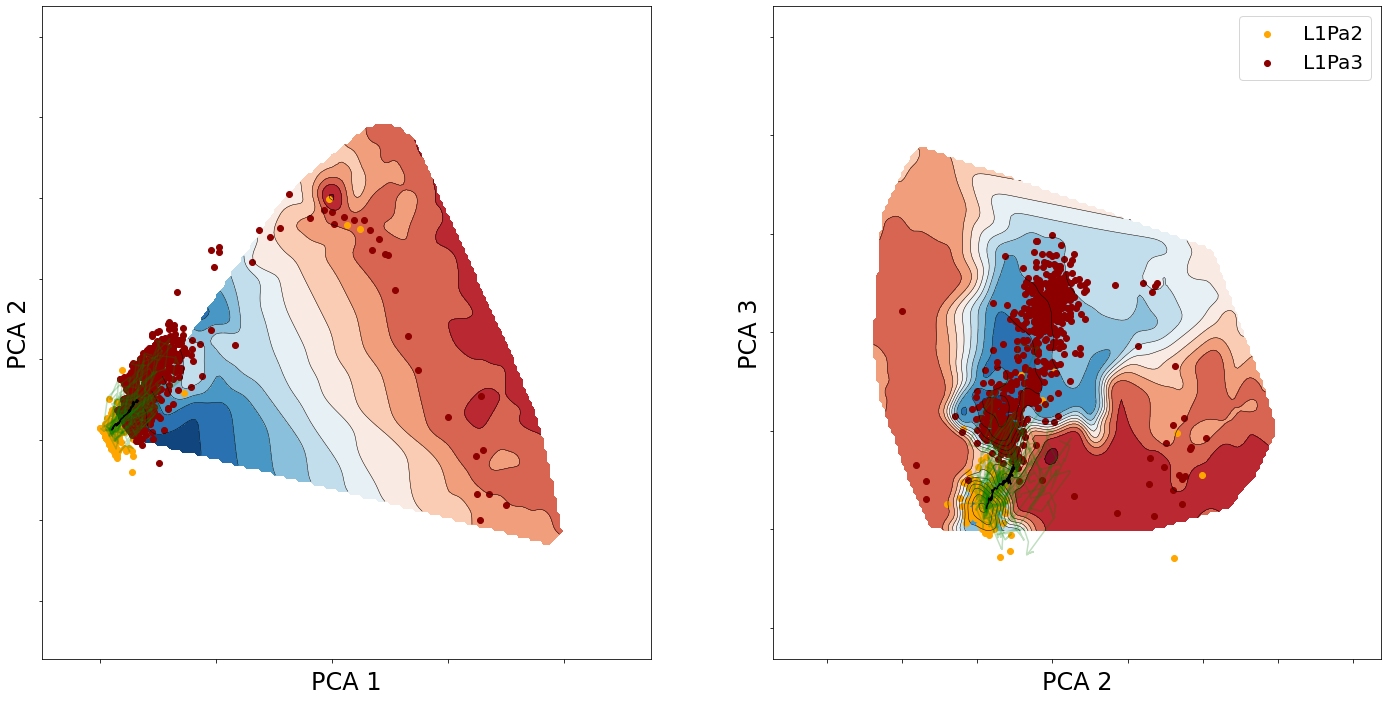

In [67]:
# PCA dimensions 2 and 3 are best for seeing the 'energy canyon'
dim_1 = 1
dim_2 = 2
msa_2 = 1
msa_3 =msa_2+1
fig1 = plt.figure(figsize=(24,12))
ax1  = fig1.add_subplot(121)    
ax2  = fig1.add_subplot(122)
planes = [(0,1), (1,2)]
axes = [ax1, ax2]
for i, (dim_1, dim_2) in enumerate(planes):
    print('plotting for dimensions %d and %d' % (dim_1, dim_2))
    x = pca_s[:,dim_1]
    y = pca_s[:,dim_2]
    z = s_E_rows[msa_2][:-len(non_evo_seqs)] # dont need to include non-evo seqs in energy


    gp2_mean_pca = np.mean(pca_s[family_indx[msa_2]], axis=0)

    # Create grid values first.
    ngridx = 200
    ngridy = 200
    xi = np.linspace(min(x)-1, max(x)+1, ngridx)
    yi = np.linspace(min(y)-1, max(y)+1, ngridy)

    # Perform linear interpolation of the data (x,y)
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z)

    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    Zi = gaussian_filter(zi, sigma=2.)

    axes[i].contour(Xi, Yi, Zi, levels=10, linewidths=0.5, colors='k')
    cntr1 = axes[i].contourf(Xi, Yi, Zi, levels=10, cmap="RdBu_r")


    axes[i].scatter(pca_s[family_indx[msa_2],dim_1], pca_s[family_indx[msa_2],dim_2], color=colors[msa_2], label=lp_names[msa_2])  
    axes[i].scatter(pca_s[family_indx[msa_3],dim_1], pca_s[family_indx[msa_3],dim_2], color=colors[msa_3], label=lp_names[msa_3])                                                                               

    mean_seq_walk = np.mean(BSW_LD_pca, axis=0)
    for seq_walk in BSW_LD_pca:
        axes[i].plot(seq_walk[:,dim_1], seq_walk[:,dim_2], c='g', alpha=.25)
    axes[i].plot(mean_seq_walk[:,dim_1], mean_seq_walk[:,dim_2], c='k')

    axes[i].set_xlabel('PCA %d' % (dim_1+1), fontsize=24)
    axes[i].set_ylabel('PCA %d' % (dim_2+1), fontsize=24)
    axes[i].get_xaxis().set_ticklabels([])
    axes[i].get_yaxis().set_ticklabels([])

plt.legend(fontsize=20)
plt.savefig('LPa23_%dwalk_%di_LPa2mean_wLPa2LD_balanced.png' % (nwalk, niter),
            transparent=True, dpi=500,bbox_inches='tight')

plt.show()

Consensus sequence:  (1329,)
25


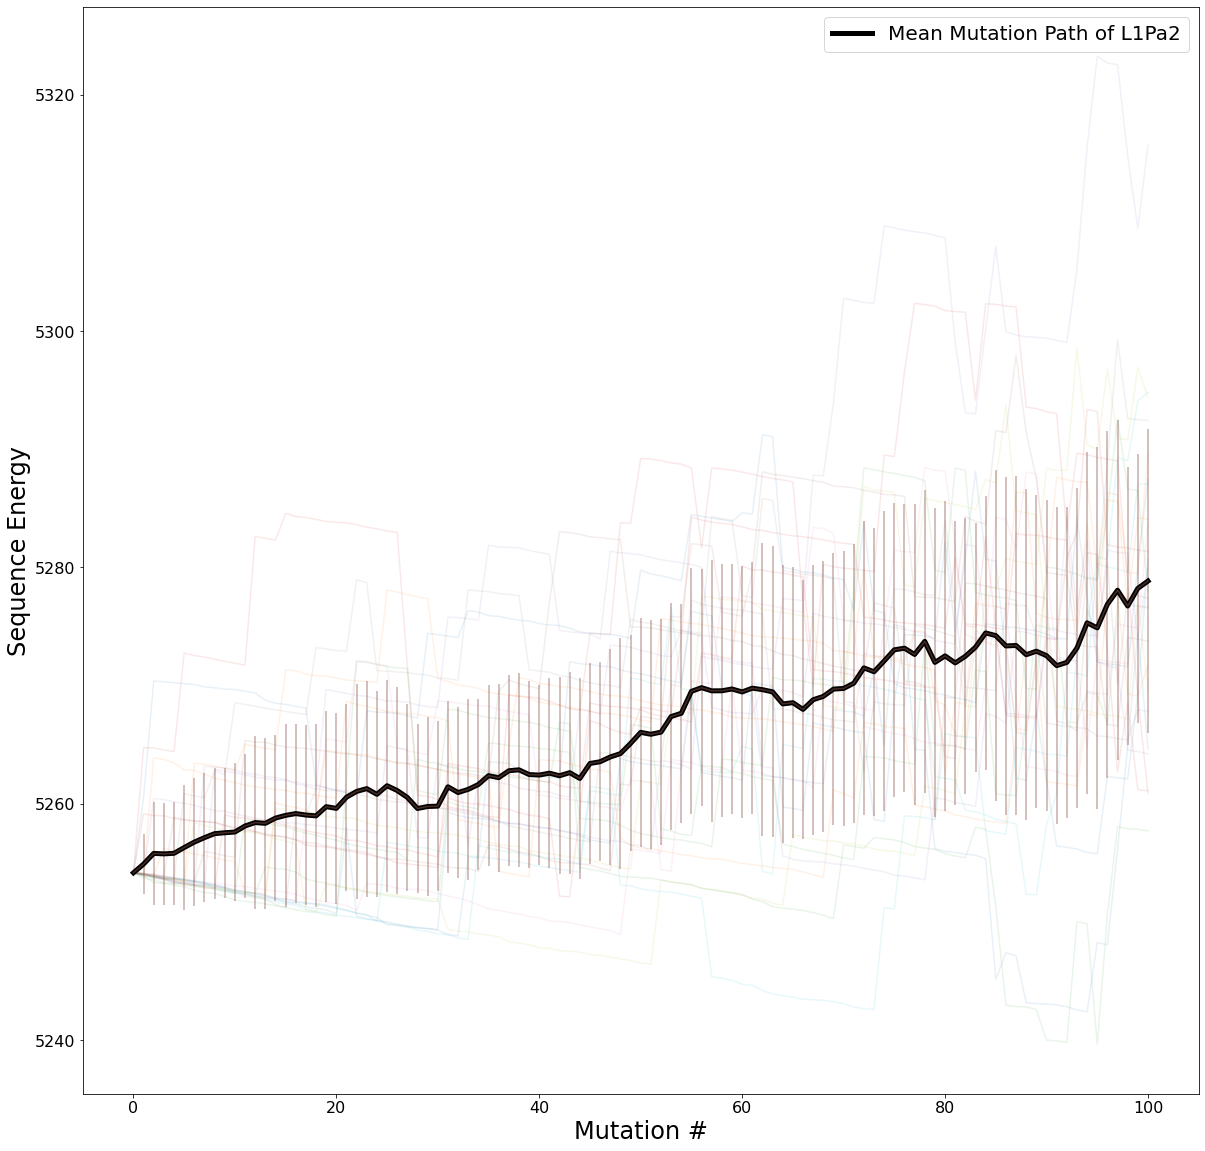

In [68]:
# Calulate sequence energy of mutated sequences from the perspective of LPa2 
# "sequence background"
msa_1 = 1

SW_LD_balanced = np.load(sequence_walk_file) # defined above

sw_E_rows = []
gp_mean = np.mean(s[family_indx[msa_2]], axis=0)
print('Consensus sequence: ', gp_mean.shape)

for i, seq_walk in enumerate(SW_LD_balanced):
    walk_energy_file = '%s/LPa23_%dwalk_%di_LPa2mean_wLPa2LD_balanced_E%d.npy' % (data_dir, nwalk,niter, i)
    if os.path.exists(walk_energy_file):
        s_E_row = np.load(walk_energy_file)
        sw_E_rows.append(s_E_row)

    else:
        seq_set = np.array([seq.reshape(len(seq),) for seq in seq_walk])
        s_E_row = np.zeros(len(seq_set))
        res = Parallel(n_jobs = 30-2)(delayed(energy_diff)
                (i1i2,gp_mean,seq_set[i0,:],w_ER,b)
                for i0 in range(len(seq_set)))
        s_E_row = np.array(res)
        sw_E_rows.append(s_E_row)
        np.save(walk_energy_file, s_E_row)
        
print(len(sw_E_rows))

fig1 = plt.figure(figsize=(20,20))
ax1  = fig1.add_subplot(111)
switches = []
for i, s_E_row in enumerate(sw_E_rows):
    ax1.plot(s_E_row, alpha = .1)
# small error need to fix 3/30
#     if switch_371:
#         ax1.scatter(switch_i,s_E_row[switch_i], marker='*', size = 150)
mean_sw_E = np.mean(sw_E_rows,axis = 0).reshape(len(sw_E_rows[0]))
std_sw_E = np.std(sw_E_rows, axis =0).reshape(len(sw_E_rows[0]))
ax1.errorbar([i for i in range(len(mean_sw_E))], mean_sw_E, std_sw_E, alpha = .5 )
ax1.plot(mean_sw_E, linewidth = 5, color = 'k', label='Mean Mutation Path of %s' % lp_names[msa_1])
plt.ylabel('Sequence Energy',fontsize = 24)
plt.xlabel('Mutation #', fontsize = 24)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
plt.legend(fontsize=20)
plt.savefig('LPa23_%dwalk_%di_LPa2mean_wLPa2LD_balanced_energy.png' % (nwalk, niter),
            transparent=True, dpi=500,bbox_inches='tight')
plt.show()